## Import packages

In [172]:
import numpy as np
import random
import operator 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import time
from pylab import rcParams
import copy
from sklearn.cluster import KMeans
import math
import matplotlib

## Define fitness function for TSP problem

In [3]:
def routeFitness(route, dm):
    dist = 0
    for i in range(len(route)-1):
        dist += dm[route[i], route[i+1]]
    dist += dm[route[-1], route[0]]
    fitness = 1/dist
    
    return fitness

## Define a function to compute euclidean matrix between points

In [4]:
def dist_matrix(df):
    list_of_distances = [] # just to make it simple, probably there are 1k better ways to do this
    for point in df.itertuples():
        a = point[1]
        b = point[2]
        for point_s in df.itertuples():
            c = point_s[1]
            d = point_s[2]
            dist = math.sqrt(((c-a)**2) + ((d-b)**2))
            list_of_distances.append(dist)
    dist_matrix = np.array(list_of_distances) # convertion to array
    dist_matrix = np.reshape(dist_matrix, (len(df), len(df))) # reshaping
    # dist_matrix.shape # check
    return dist_matrix

## Define a function to initialize our population

In [5]:
def initPopulation(popSize, cities):
    population = []
    [population.append(random.sample(cities, len(cities))) for i in range(0, popSize)]
#     for i in range(0, popSize):
#         population.append(createRoute(cityList))
    return population

## Define a function to compute the error

In [6]:
def errPerc(exactValue, currValue, nRound = 2):
    errp = round((abs(exactValue - currValue) / exactValue)*100, nRound)
    return errp

## Define a function to plot our results

In [277]:
def plot(points, path: list, name_tsp, save = False):
    x = []
    y = []
    for point in points.itertuples():
        x.append(point[1])
        y.append(point[2])
    
    y = list(map(operator.sub, [max(y) for i in range(len(points))], y))
    plt.plot(x, y, 'co', markersize = 4, alpha = 0.8)

    for _ in range(1, len(path)):
        i = path[_ - 1]
        j = path[_]

        plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='r',
                  length_includes_head=True, linewidth = 0.3, alpha = 0.8)

    #plt.xlim(0, max(x) * 1.1)

    #plt.ylim(0, max(y) * 1.1)
    
    label_t = 'Best route for {}'.format(name_tsp)
    plt.title(label_t, loc='center')
    if save:
        plt.savefig('figs/best_{}.png'.format(name_tsp), dpi = 300)

## Define the main algorithm

In [361]:
def GenA(permutation, dm, popSize, selection, elite_n, mutation_r, n_of_gen, plot = False, verbose = False):
    start = time.time()
    pop = initPopulation(popSize, permutation)
    fitness = {}
    [fitness.update({i:routeFitness(pop[i], dm)}) for i in range(0,len(pop))]
    rankedRoutes = sorted(fitness.items(), key = operator.itemgetter(1), reverse = True)
    traceBest = 1/rankedRoutes[0][1]
    
    if plot:
        progress = []
        progress.append(1 / rankedRoutes[0][1])
    
    if verbose:
        print("Initial distance: " + str(1 / rankedRoutes[0][1]))
    
    for k in range(0, n_of_gen):

        ##################
        # Ranking routes #
        ##################
        
        fitness = {}
        [fitness.update({i:routeFitness(pop[i], dm)}) for i in range(0,len(pop))]
        rankedRoutes = sorted(fitness.items(), key = lambda kv: kv[1], reverse = True)
        if 1/rankedRoutes[0][1] < traceBest:
            traceBest = 1/rankedRoutes[0][1]
            traceBestRouteIndex = rankedRoutes[0][0]
            traceBestRoute = pop[traceBestRouteIndex]
        ########
        # plot #
        ########
        
        if plot:
            progress.append(1 / rankedRoutes[0][1])

        #############
        # selection #
        #############
        
        if selection == 'roulette-wheel':
            selectionR = []
            df = pd.DataFrame(np.array(rankedRoutes), columns=["Index","Fitness"])
            df['cum_sum'] = df.Fitness.cumsum()
            df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
        
            [selectionR.append(rankedRoutes[i][0]) for i in range(0, elite_n)]
        
            for i in range(0, len(rankedRoutes) - elite_n):
                pick = 100*random.random()
                for i in range(0, len(rankedRoutes)):
                    if pick <= df.iat[i,3]:
                        selectionR.append(rankedRoutes[i][0])
                        break
        
        elif selection == 'tournament':
            selectionR = []
            while len(selectionR) < len(pop):
                fighters = random.sample(rankedRoutes, random.randint(2, len(rankedRoutes)))
                winner = max(fighters, key = operator.itemgetter(1))[0]
                selectionR.append(winner)
                
                # deprecated code
                
#                 fighter_1 = fighters[0]
#                 fighter_2 = fighters[1]
#                 if fighter_1[1] >= fighter_2[1]:
#                     winner = fighter_1[0]
#                 else:
#                     winner = fighter_2[0]
#                 selectionR.append(winner)
#             del rank
#             df = pd.DataFrame(np.array(rankedRoutes), columns=["Index","Fitness"])
#             df['cum_sum'] = df.Fitness.cumsum()
#             df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
#             for i in range(0, len(rankedRoutes) - elite_n):
#                 pick = 100*random.random()
#                 for i in range(0, len(rankedRoutes)):
#                     if pick <= df.iat[i,3]:
#                         selectionR.append(rankedRoutes[i][0])
#                         break
        else:
            print("Only roulette-wheel and tournament are suitable selection options")
            break
            
        ###############
        # mating pool #
        ###############
        
        mp = []
        [mp.append(pop[selectionR[i]]) for i in range(0, len(selectionR))]

        #############
        # Crossover #
        #############
        
        children = []
        length = (len(mp) - elite_n)
        pool = random.sample(mp, len(mp))
        [children.append(mp[i]) for i in range(0, elite_n)]
        
        for i in range(0, length):
            parent1 = pool[i]
            parent2 = pool[len(mp)-i-1]
            child = []
            childP1 = []
            childP2 = []
    
            geneA = int(random.random() * len(parent1))
            geneB = int(random.random() * len(parent1))
            
            startGene = min(geneA, geneB)
            endGene = max(geneA, geneB)
            [childP1.append(parent1[i]) for i in range(startGene, endGene)]
            childP2 = [item for item in parent2 if item not in childP1]
            
            child = childP1 + childP2
            children.append(child)
        
        ############
        # mutation #
        ############
        
        mutatedPop = []
    
        for ind in range(0, len(children)):
            individual = children[ind]
            for swapped in range(len(individual)):
                if(random.random() < mutation_r):
                    swapWith = int(random.random() * len(individual))
            
                    city1 = individual[swapped]
                    city2 = individual[swapWith]
            
                    individual[swapped] = city2
                    individual[swapWith] = city1
            mutatedPop.append(individual)
        
        ##############
        # update pop #
        ##############
        
        pop = mutatedPop
        
    
    
    ###########
    # results #
    ###########
    
    fitness = {}
    [fitness.update({i:routeFitness(pop[i], dm)}) for i in range(0,len(pop))]
    rankedRoutes = sorted(fitness.items(), key = lambda kv: kv[1], reverse = True)
    
    if 1/rankedRoutes[0][1] < traceBest:
        traceBest = 1/rankedRoutes[0][1]
        traceBestRouteIndex = rankedRoutes[0][0]
        traceBestRoute = pop[traceBestRouteIndex]
        
    bestDistance = traceBest #1 / rankedRoutes[0][1]
    if verbose:
        print("Final distance: {}".format(bestDistance))
    bestRouteIndex = traceBestRouteIndex #rankedRoutes[0][0]
    bestRoute = traceBestRoute #pop[bestRouteIndex]
    time_executed = (time.time() - start)
    
    if verbose:
        print("Algorithm completed in {} s".format(time_executed))
    
    if plot:
        rcParams['figure.figsize'] = 15, 5
        plt.plot(progress)
        plt.ylabel('Distance')
        plt.xlabel('Generation')
        plt.show()
    
    return bestRoute, bestDistance, time_executed

## Running the algorithm

Import our data

In [345]:
df_dj38 = pd.read_csv("data/dj38.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df_berlin52 = pd.read_csv("data/berlin52.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df_ch130 = pd.read_csv("data/ch130.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df_d198 = pd.read_csv("data/d198.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
df_pr1002 = pd.read_csv("data/pr1002.tsp", header=None, sep = " ", names = ['x', 'y'], index_col = 0)
bestKnown_tsp = {
    'dj38':6656,
    'berlin52':7542,
    'ch130':6110,
    'd198':15780,
    'pr1002':259045}
list_dist = []
list_time = []
list_route = []
list_errp = []

### dj38

In [10]:
cities = []
cities = list(range(len(df_dj38)))
d_matrix = dist_matrix(df_dj38)

Initial distance: 22725.94297638195
Final distance: 6675.3614443072165
Algorithm completed in 32.149046182632446 s


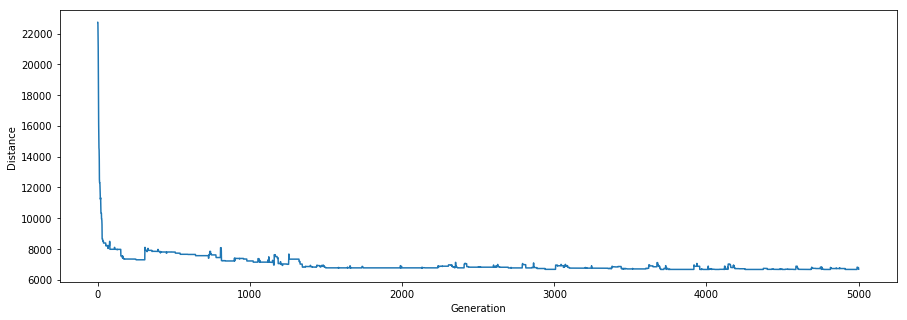

With an error to minimal value of: 0.29%


In [108]:
route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                         popSize = 100,
                         selection = 'tournament',
                         elite_n = 25,
                         mutation_r = 0.01,
                         n_of_gen = 5000,
                           plot = True)

errp = errPerc(bestKnown_tsp['dj38'], dist, 2)
print('With an error to minimal value of: {}%'.format(errp))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(route)
list_errp.append(errp)

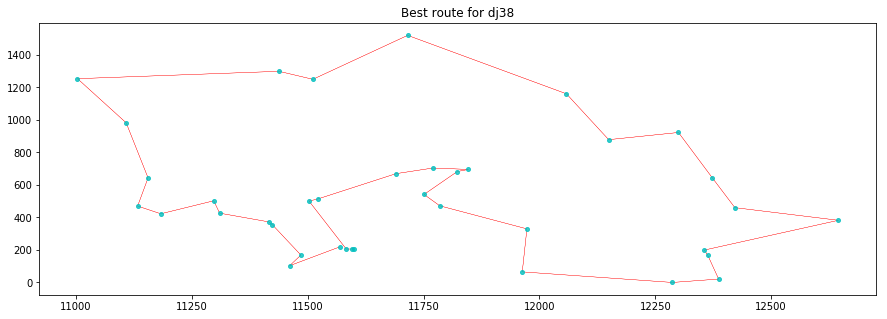

In [109]:
plot(df_dj38, route, 'dj38')

### berlin52

In [110]:
cities = []
cities = list(range(len(df_berlin52)))
d_matrix = dist_matrix(df_berlin52)

Initial distance: 24819.426055377757
Final distance: 8380.04938690444
Algorithm completed in 36.822580099105835 s


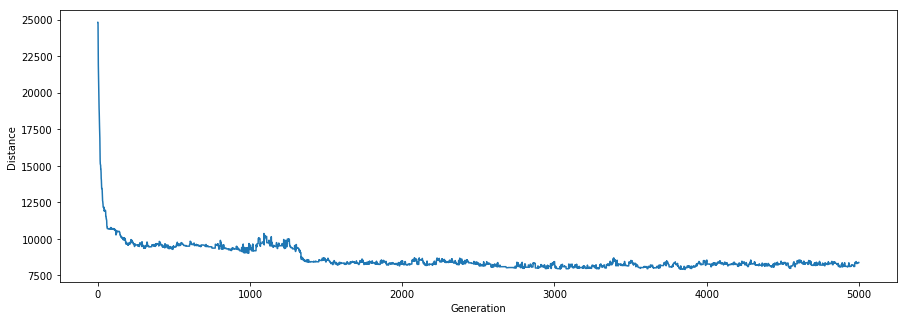

With an error to minimal value of: 11.11%


In [111]:
route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                         popSize = 100,
                         selection = 'tournament',
                         elite_n = 25,
                         mutation_r = 0.01,
                         n_of_gen = 5000,
                           plot = True)

errp = errPerc(bestKnown_tsp['berlin52'], dist, 2)
print('With an error to minimal value of: {}%'.format(errp))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(route)
list_errp.append(errp)

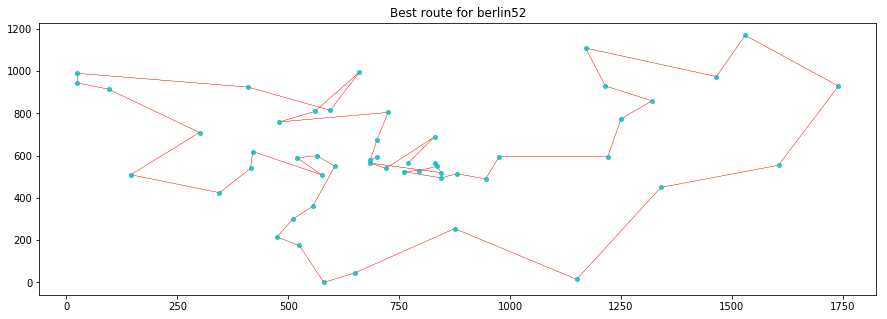

In [112]:
plot(df_berlin52, route, 'berlin52')

### ch130

In [113]:
cities = []
cities = list(range(len(df_ch130)))
d_matrix = dist_matrix(df_ch130)

Initial distance: 42367.28248708102
Final distance: 15865.164024688991
Algorithm completed in 69.4044406414032 s


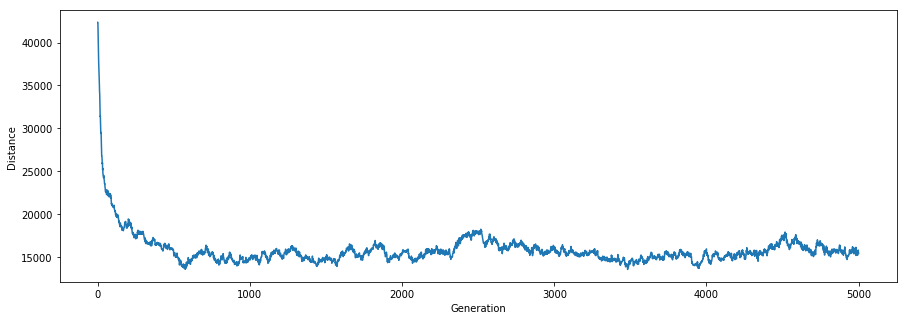

With an error to minimal value of: 159.66%


In [114]:
route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                         popSize = 100,
                         selection = 'tournament',
                         elite_n = 25,
                         mutation_r = 0.01,
                         n_of_gen = 5000,
                           plot = True)

errp = errPerc(bestKnown_tsp['ch130'], dist, 2)
print('With an error to minimal value of: {}%'.format(errp))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(route)
list_errp.append(errp)

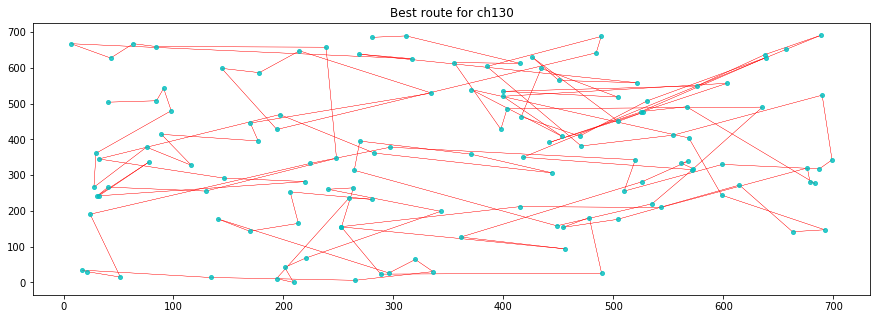

In [115]:
plot(df_ch130, route, 'ch130')

### d198

In [296]:
cities = []
cities = list(range(len(df_d198)))
d_matrix = dist_matrix(df_d198)

Initial distance: 169332.64677821763
Final distance: 44185.622171881
Algorithm completed in 107.93941521644592 s


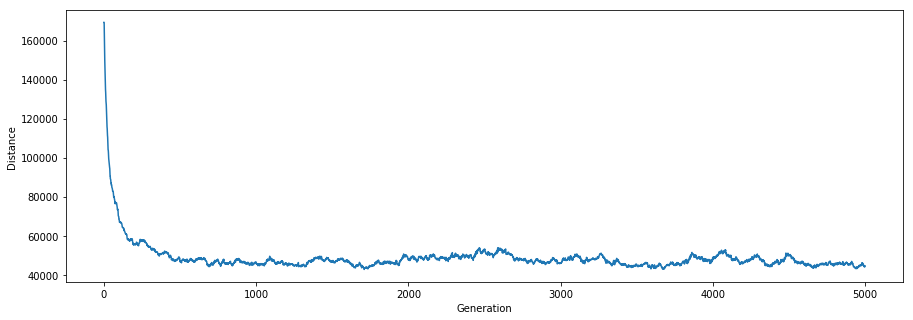

With an error to minimal value of: 180.01%


In [117]:
route, dist, time_ex = GenA(permutation = cities, dm = d_matrix,
                         popSize = 100,
                         selection = 'tournament',
                         elite_n = 25,
                         mutation_r = 0.01,
                         n_of_gen = 5000,
                           plot = True)

errp = errPerc(bestKnown_tsp['d198'], dist, 2)
print('With an error to minimal value of: {}%'.format(errp))
list_dist.append(dist)
list_time.append(time_ex)
list_route.append(route)
list_errp.append(errp)

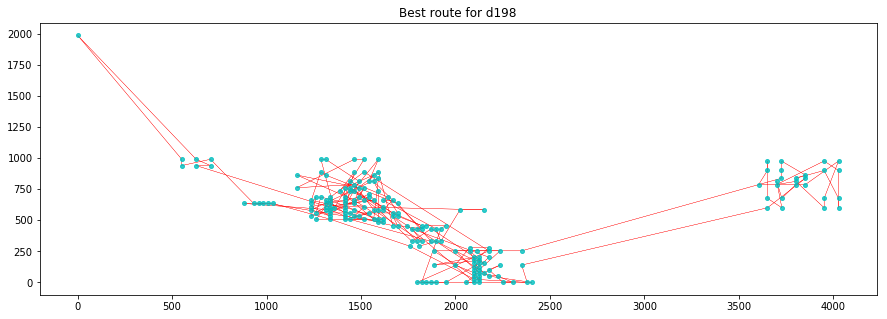

In [118]:
plot(df_d198, route, 'd198')

## Results

In [119]:
ndx = list(bestKnown_tsp.keys())

In [120]:
list_best_dist = list(bestKnown_tsp.values())
list_tuples = list(zip(list_best_dist,list_dist, list_time, list_errp))
results = pd.DataFrame(list_tuples, columns = ['bestDistance', 'distance', 'time', 'error%'], index = ndx)
results

,bestDistance,distance,time,error%
dj38,6656,6675.361444,32.149046,0.29
berlin52,7542,8380.049387,36.822580,11.11
ch130,6110,15865.164025,69.404441,159.66
d198,15780,44185.622172,107.939415,180.01


## K-means with GA (KGA)

First of all we define a function that create a list of clusters

In [ ]:
def list_of_clusters(kMeans_results):
    list_of_clusters = []
    for i in range(0, len(np.unique(kMeans_results))):
        tmp = np.where(kMeans_results == i)[0].tolist()
        list_of_clusters.append(tmp)
               
    return list_of_clusters

With KGA we use GA inside every cluster we created

In [ ]:
def KGA(list_of_clusters, dm, popSize, selection, elite_n, mutation_r, n_of_gen, plot):
    listClusterRoute = []
    for elem in list_of_clusters:
        tmpBestRoute = GenA(permutation = elem, dm = dm,
                         popSize = popSize,
                         selection = selection,
                         elite_n = elite_n,
                         mutation_r = mutation_r,
                         n_of_gen = n_of_gen,
                           plot = plot)[0]
        
        plot(df_dj38, tmpBestRoute, 'dj38Partial')
        listClusterRoute.append(tmpBestRoute)
    return listClusterRoute

With join_cluster we re-construct the entire list of cities from the previous cluster

In [ ]:
def join_cluster(clu1, clu2, d_matrix):
    value = None
    for i in range(len(clu1)):
        for j in range(len(clu2)):
            tmp = d_matrix[clu1[i],clu2[j]]
            if value is None:
                value=tmp
                i_min= i
                j_min = j
            if tmp < value:
                value = tmp
                i_min= i
                j_min = j

    i_min1 = i_min - 1

    j_min1 = j_min -1

    if i_min != len(clu1)-1:
        i_plu1 = i_min + 1
    else:
        i_plu1 = 0

    if j_min != len(clu2)-1:
        j_plu1 = j_min + 1
    else:
        j_plu1 = 0

    #list1 = [clu1[i_min1], clu1[i_plu1]]
    #list2 = [clu2[j_min1], clu2[j_plu1]]

    del tmp
    carlo = np.array([i_min1, i_plu1, j_min1, j_plu1]).reshape(2,2)
    # carlo
    d_ij = d_matrix[clu1[i_min], clu2[j_min]]
    #print(carlo)
    best_norm=None
    best_ip = 0
    best_jp = 0
    for i in carlo[0]:
        d_iip = d_matrix[clu1[i_min], clu1[i]]
        d_ipj = d_matrix[clu2[j_min], clu1[i]]
        for j in carlo[1]:
            
            d_jjp = d_matrix[clu2[j_min], clu2[j]]
            d_ijp = d_matrix[clu1[i_min], clu2[j]]
            d_ipjp = d_matrix[clu1[i], clu2[j]]
            tmp  = d_ij + d_ipjp-d_iip-d_jjp
            tmp1 = d_ijp + d_ipj -d_iip-d_jjp
            n_tmp= math.pow(math.pow(tmp,2)+math.pow(tmp1,2), 1/2 )

            if best_norm is None:
                #print(tmp, tmp1, n_tmp)
                best_norm=n_tmp
                best_jp=j
                best_ip=i

            elif n_tmp < best_norm:
                best_norm=n_tmp
                best_jp=j
                best_ip=i

    #print(carlo,best_ip, best_jp)

    new_seq_i=clu1[best_ip:]+clu1[:best_ip]
    new_seq_j=clu2[best_jp:]+clu2[:best_jp]


    tot_seq_ipjpbestcarlos=new_seq_i+new_seq_j
    return tot_seq_ipjpbestcarlos

## dj38

In [267]:
clustering = KMeans(n_clusters = 3, n_init = 100).fit(df_dj38)
results = clustering.labels_
centroid_df = pd.DataFrame(clustering.cluster_centers_)
centroids = []
centroids = list(range(len(centroid_df)))
d_matrixCentroid = dist_matrix(centroid_df)
d_matrix = dist_matrix(df_dj38)
centroids

[0, 1, 2]

In [268]:
1/routeFitness(centroids, d_matrixCentroid)

2786.6643151131757

In [269]:
ordered_centroids = GenA(centroids,
                         d_matrixCentroid, 
                         popSize = 100,
                         selection = 'roulette-wheel',
                         elite_n=25,
                         mutation_r=0.01,
                         n_of_gen = 100)[0]

Initial distance: 2786.6643151131757
Final distance: 2786.6643151131757
Algorithm completed in 3.3989064693450928 s


In [270]:
ordered_centroids

[0, 2, 1]

In [271]:
obj = list_of_clusters(results)
obj1 = []
[obj1.append(obj[elem]) for elem in ordered_centroids]
# obj1 = sorted(obj, key = operator.itemgetter(ordered_centroids))
obj1

[[26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37],
 [0, 1, 9, 13, 20, 28],
 [2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25]]

In [272]:
obj

[[26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37],
 [2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25],
 [0, 1, 9, 13, 20, 28]]

Initial distance: 3747.9696258351346
Final distance: 2667.7590215384253
Algorithm completed in 28.68940830230713 s


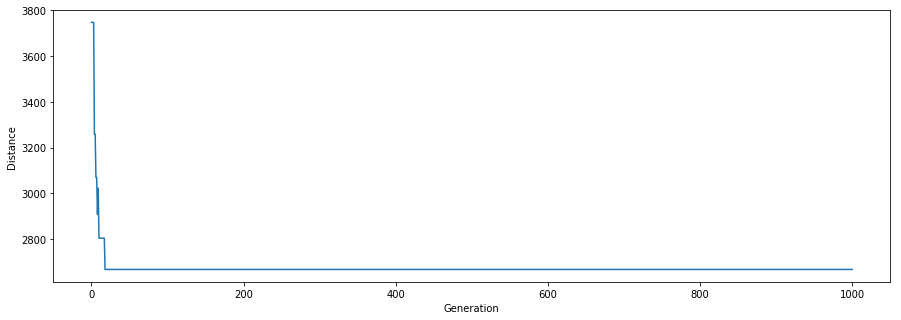

Initial distance: 2617.0593244823176
Final distance: 2617.0593244823176
Algorithm completed in 27.989128351211548 s


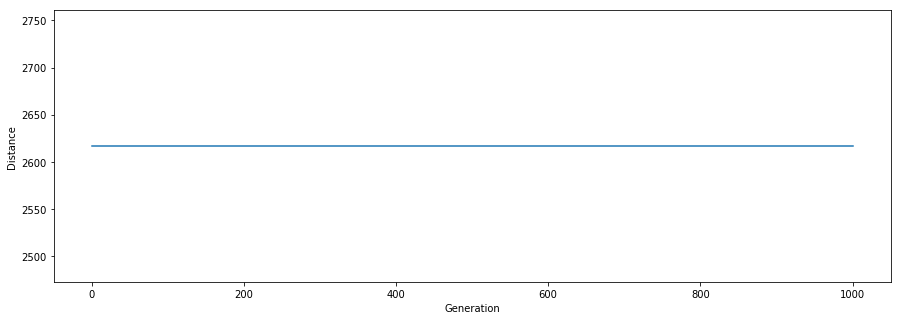

Initial distance: 5263.407947029319
Final distance: 2376.990697206687
Algorithm completed in 28.860154628753662 s


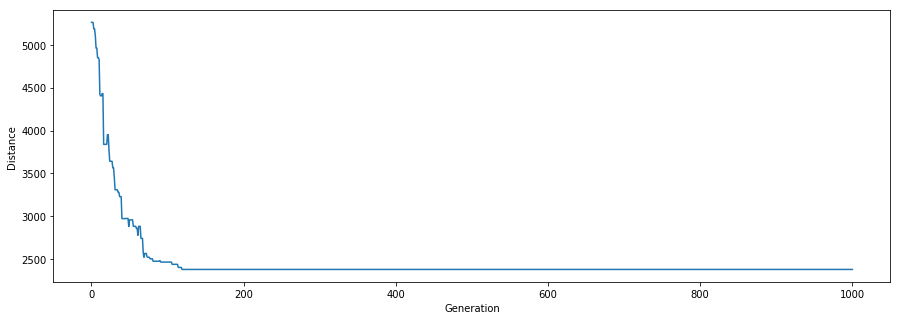

In [273]:
Clusterdj38 = KGA(obj1,
                  dm = d_matrix,
                  popSize=100,
                  selection='roulette-wheel',
                  elite_n=25,
                  mutation_r=0.01,
                  n_of_gen=100,
                  plot = True)

In [274]:
Clusterdj38

[[33, 32, 37, 36, 34, 31, 29, 27, 26, 30, 35],
 [28, 20, 9, 0, 1, 13],
 [3, 5, 12, 14, 19, 22, 25, 24, 21, 23, 18, 17, 16, 15, 11, 10, 8, 7, 6, 4, 2]]

In [275]:
clu_start = Clusterdj38[0]
for i in range(1,len(Clusterdj38)):
    clu_start = join_cluster(clu_start,Clusterdj38[i], d_matrix)

In [276]:
1/routeFitness(clu_start, d_matrix)

9780.837510544521

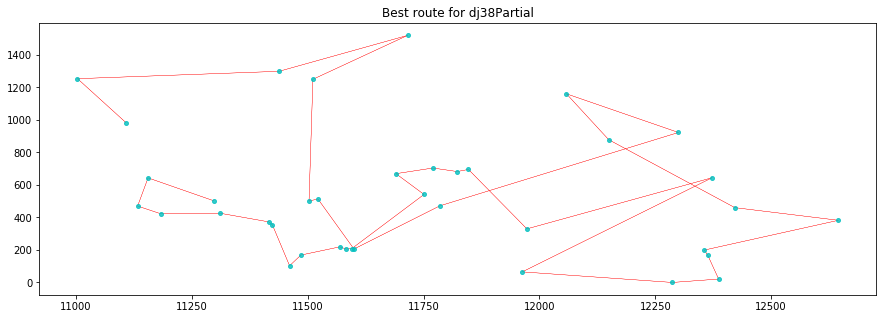

In [250]:
plot(df_dj38, clu_start, 'dj38 KGA')

## d198

In [334]:
clustering = KMeans(n_clusters = 30, n_init = 100).fit(df_d198)
results = clustering.labels_
centroid_df = pd.DataFrame(clustering.cluster_centers_)
centroids = []
centroids = list(range(len(centroid_df)))
d_matrixCentroid = dist_matrix(centroid_df)
d_matrix = dist_matrix(df_d198)
centroids

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [335]:
1/routeFitness(centroids, d_matrixCentroid)

43092.148050888805

In [336]:
ordered_centroids = GenA(centroids,
                         d_matrixCentroid, 
                         popSize = 100,
                         selection = 'roulette-wheel',
                         elite_n=25,
                         mutation_r=0.01,
                         n_of_gen = 100)[0]

Initial distance: 28086.377443185353
Final distance: 13800.856614018263
Algorithm completed in 3.3972017765045166 s


In [337]:
ordered_centroids

[7,
 4,
 0,
 22,
 13,
 21,
 29,
 23,
 2,
 11,
 14,
 17,
 8,
 10,
 19,
 1,
 24,
 5,
 26,
 9,
 12,
 16,
 6,
 3,
 20,
 15,
 27,
 25,
 18,
 28]

In [338]:
obj = list_of_clusters(results)
obj1 = []
[obj1.append(obj[elem]) for elem in ordered_centroids]

# obj1 = sorted(obj, key = operator.itemgetter(ordered_centroids))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [311]:
obj1

[[104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,

In [339]:
Clusterd198 =  KGA(obj1,
                  dm = d_matrix,
                  popSize=100,
                  selection='roulette-wheel',
                  elite_n=25,
                  mutation_r=0.01,
                  n_of_gen=100,
                  plot = False)

Initial distance: 547.9339575693383
Final distance: 416.86016489386304
Algorithm completed in 3.0791962146759033 s
Initial distance: 457.1999999999998
Final distance: 457.1999999999998
Algorithm completed in 2.6749439239501953 s
Initial distance: 390.244610179245
Final distance: 390.244610179245
Algorithm completed in 2.9255635738372803 s
Initial distance: 643.367059909229
Final distance: 455.27378312812976
Algorithm completed in 3.5358030796051025 s
Initial distance: 304.8000000000002
Final distance: 304.8000000000002
Algorithm completed in 3.118055582046509 s
Initial distance: 299.5999999999999
Final distance: 299.5999999999999
Algorithm completed in 3.042179584503174 s
Initial distance: 286.44734952929747
Final distance: 286.44734952929747
Algorithm completed in 3.3672895431518555 s
Initial distance: 304.80000000000064
Final distance: 304.80000000000064
Algorithm completed in 2.8667352199554443 s
Initial distance: 253.99999999999912
Final distance: 234.59612662849386
Algorithm compl

C:\Users\fabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


Final distance: 0.0
Algorithm completed in 0.3041229248046875 s
Initial distance: 406.4000000000001
Final distance: 406.4000000000001
Algorithm completed in 2.6324079036712646 s
Initial distance: 289.921024484277
Final distance: 289.921024484277
Algorithm completed in 2.7989282608032227 s
Initial distance: 718.8383643943275
Final distance: 527.7935023068671
Algorithm completed in 2.919620990753174 s
Initial distance: 499.95425805056027
Final distance: 372.11715111277135
Algorithm completed in 2.705937623977661 s
Initial distance: 409.7325501669469
Final distance: 348.7782208774963
Algorithm completed in 3.1268198490142822 s
Initial distance: 411.45647835922716
Final distance: 363.84370513655364
Algorithm completed in 2.8347973823547363 s
Initial distance: 304.8000000000002
Final distance: 304.8000000000002
Algorithm completed in 3.206185817718506 s


In [ ]:
Clusterdj38

In [342]:
clu_start = Clusterd198[0]
for i in range(1,len(Clusterd198)):
    clu_start = join_cluster(clu_start,Clusterd198[i], d_matrix)

In [343]:
1/routeFitness(clu_start, d_matrix)

22382.157276113776

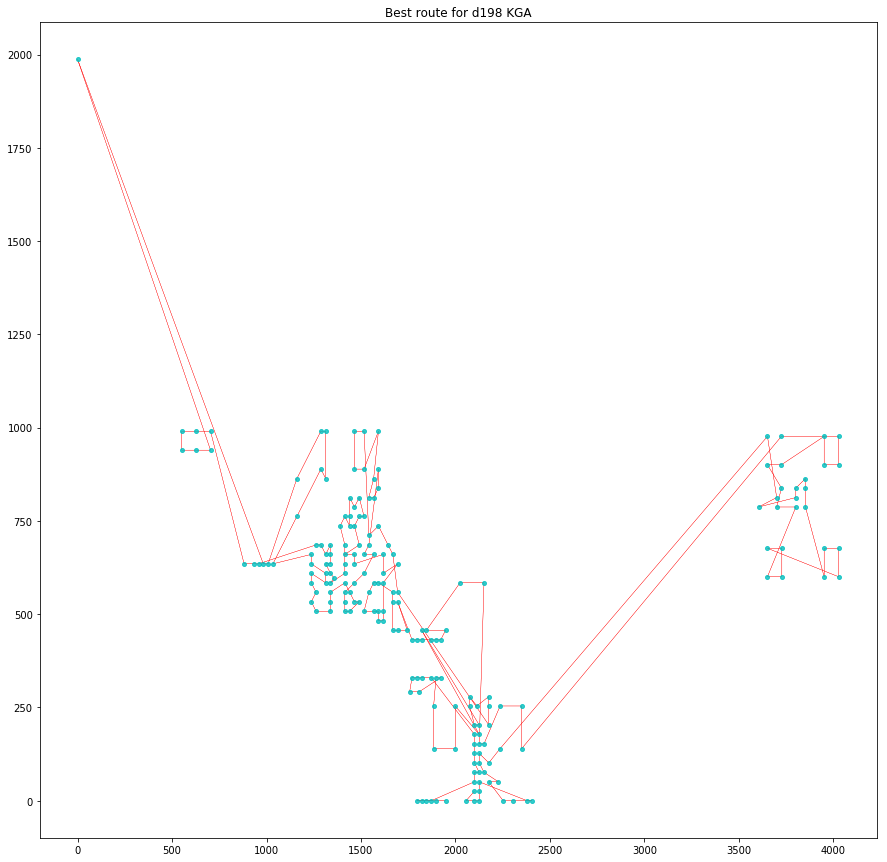

In [344]:
rcParams['figure.figsize'] = 15,15
plot(df_d198, clu_start, 'd198 KGA')

## pr1002

In [348]:
clustering = KMeans(n_clusters = 100, n_init = 100).fit(df_pr1002)
results = clustering.labels_
centroid_df = pd.DataFrame(clustering.cluster_centers_)
centroids = []
centroids = list(range(len(centroid_df)))
d_matrixCentroid = dist_matrix(centroid_df)
d_matrix = dist_matrix(df_pr1002)

In [349]:
ordered_centroids = GenA(centroids,
                         d_matrixCentroid, 
                         popSize = 100,
                         selection = 'tournament',
                         elite_n=25,
                         mutation_r=0.01,
                         n_of_gen = 100)[0]

In [352]:
obj = list_of_clusters(results)
obj1 = []
[obj1.append(obj[elem]) for elem in ordered_centroids]
print('done')

done


In [357]:
Clusterpr1002 =  KGA(obj1,
                  dm = d_matrix,
                  popSize=100,
                  selection='roulette-wheel',
                  elite_n=25,
                  mutation_r=0.01,
                  n_of_gen=100,
                  plot = False)

C:\Users\fabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [358]:
clu_start = Clusterpr1002[0]
for i in range(1,len(Clusterpr1002)):
    clu_start = join_cluster(clu_start,Clusterpr1002[i], d_matrix)

In [359]:
1/routeFitness(clu_start, d_matrix)

401885.7042144714

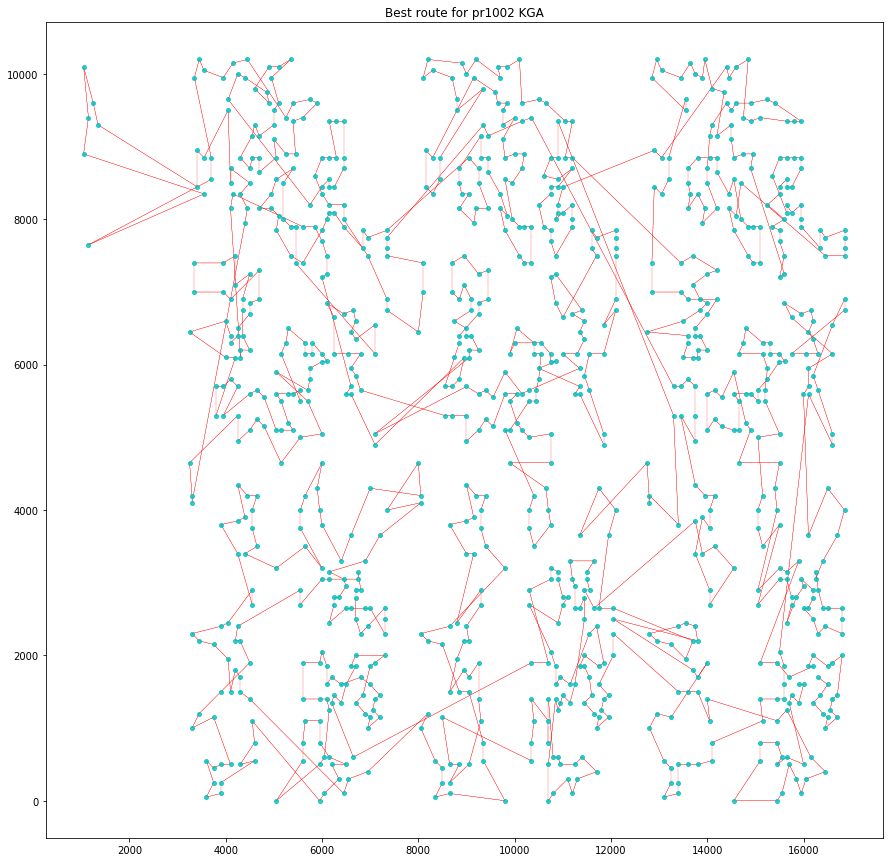

In [360]:
rcParams['figure.figsize'] = 15,15
plot(df_pr1002, clu_start, 'pr1002 KGA')